# PHYS 512 - Problem Set 5

**André Vallières (260742187)**

## Problem 1

In [20]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import signal

### a)

#### Code for reading files

In [21]:
EVENTS_DIRECTORY = 'LOSC_Event_tutorial/'

FILES = [
    {
        "name": "GW150914",
        "event_H": "H-H1_LOSC_4_V2-1126259446-32.hdf5",
        "event_L": "L-L1_LOSC_4_V2-1126259446-32.hdf5",
        "template": "GW150914_4_template.hdf5"
    },
    {
        "name": "LVT151012",
        "event_H": "H-H1_LOSC_4_V2-1128678884-32.hdf5",
        "event_L": "L-L1_LOSC_4_V2-1128678884-32.hdf5",
        "template": "LVT151012_4_template.hdf5"
    },
    {
        "name": "GW151226",
        "event_H": "H-H1_LOSC_4_V2-1135136334-32.hdf5",
        "event_L": "L-L1_LOSC_4_V2-1135136334-32.hdf5",
        "template": "GW151226_4_template.hdf5"
    },
    {
        "name": "GW170104",
        "event_H": "H-H1_LOSC_4_V1-1167559920-32.hdf5",
        "event_L": "L-L1_LOSC_4_V1-1167559920-32.hdf5",
        "template": "GW170104_4_template.hdf5"
    }
]

def read_template(filename):
    dataFile = h5py.File(os.path.join(EVENTS_DIRECTORY, filename), 'r')
    template = dataFile['template']
    th = template[0]
    tl = template[1]
    return th, tl

def read_file(filename):
    dataFile = h5py.File(os.path.join(EVENTS_DIRECTORY, filename), 'r')
    dqInfo = dataFile['quality']['simple']
    qmask = dqInfo['DQmask'][...]

    meta = dataFile['meta']
    #gpsStart=meta['GPSstart'].value
    gpsStart = meta['GPSstart'][()]
    #print meta.keys()
    #utc=meta['UTCstart'].value
    utc = meta['UTCstart'][()]
    #duration=meta['Duration'].value
    duration = meta['Duration'][()]
    #strain=dataFile['strain']['Strain'].value
    strain = dataFile['strain']['Strain'][()]
    dt = (1.0 * duration) / len(strain)

    dataFile.close()
    
    return strain, dt, utc

#### Noise models

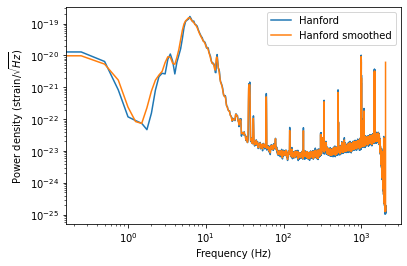

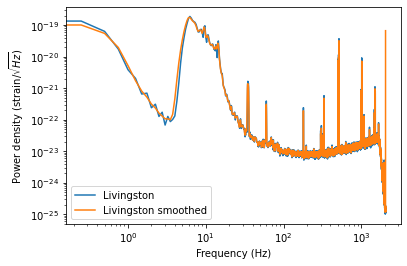

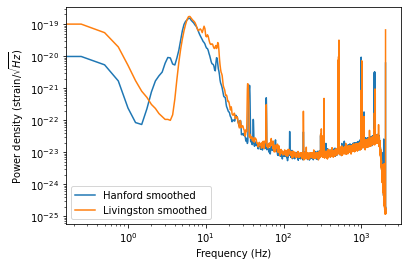

In [43]:
def gaussian_smooth(x, std=1):
    # Convert input to frequency domain
    fft = np.fft.fft(x)
    
    # Prepare a Gaussian
    n = np.arange(len(x))
    gaussian = np.exp(-0.5 * (n/std)**2)
    gaussian = gaussian + gaussian[::-1]
    gaussian = gaussian/np.sum(gaussian)
    
    # Convert kernel to frequency domain
    gaussian_fft = np.fft.fft(gaussian)

    # Convolve with Gaussian kernel
    return np.abs(np.fft.ifft(fft * gaussian_fft))

file = FILES[0]
alpha = 0.125
std = 2.
plot = True

event_H = file["event_H"]
event_L = file["event_L"]
template = file["template"]

# Read files
H_strain, H_dt, _ = read_file(event_H)
L_strain, L_dt, _ = read_file(event_L)

H_template, L_template = read_template(template)

# Get window to eliminate effects of non-periodic boundaries in the data
window = signal.tukey(len(H_strain), alpha) # Tapered in the center

# Window both signals and templates
H_strain = H_strain * window
L_strain = L_strain * window

H_template = H_template * window
L_template = L_template * window

# Use of Welch's method (better spectrogram estimation)
fs = 1.0/H_dt # 4096
H_freqs, H_noise = signal.welch(H_strain, fs, window="blackman", nperseg=4 * fs) # 4 sec
L_freqs, L_noise = signal.welch(L_strain, fs, window="blackman", nperseg=4 * fs)

# Smooth
H_noise_smooth = gaussian_smooth(H_noise, std)
L_noise_smooth = gaussian_smooth(L_noise, std)

template_fft = np.fft.rfft(H_template)

if plot:
    plt.figure()
    plt.loglog(H_freqs, np.sqrt(H_noise))
    plt.loglog(H_freqs, np.sqrt(H_noise_smooth))
    plt.legend(["Hanford", "Hanford smoothed"])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel(r'Power density (strain/$\sqrt{Hz}$)')
    plt.show()
    
    plt.figure()
    plt.loglog(L_freqs, np.sqrt(L_noise))
    plt.loglog(L_freqs, np.sqrt(L_noise_smooth))
    plt.legend(["Livingston", "Livingston smoothed"])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel(r'Power density (strain/$\sqrt{Hz}$)')
    plt.show()
    
    plt.figure()
    plt.loglog(H_freqs, np.sqrt(H_noise_smooth))
    plt.loglog(L_freqs, np.sqrt(L_noise_smooth))
    plt.legend(["Hanford smoothed", "Livingston smoothed"])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel(r'Power density (strain/$\sqrt{Hz}$)')
    plt.show()

In [27]:
def get_noise_models(smoothing_std=5, alpha=0.125, plot=True):
    noise_models = []
    for file in FILES:
        # Get file names
        event_H = file["event_H"]
        event_L = file["event_L"]
        template = file["template"]

        # Read files
        H_strain, H_dt, _ = read_file(event_H)
        L_strain, L_dt, _ = read_file(event_L)

        H_template, L_template = read_template(template)

        # Compute FFT (windowed)
        window = signal.tukey(len(H_strain), alpha) # Tapered
        
        # Assume it's all noise
        H_noise = np.abs(np.fft.rfft(H_strain * window))
        L_noise = np.abs(np.fft.rfft(L_strain * window))

        H_freqs = np.arange(len(H_noise)) / (len(H_noise) * H_dt)
        L_freqs = np.arange(len(L_noise)) / (len(L_noise) * L_dt)

        # Smooth spectrum by convolution with Gaussian
        L_noise_smooth = gaussian_smooth(L_noise, smoothing_std)
        H_noise_smooth = gaussian_smooth(H_noise, smoothing_std)
        
        # Make sure same length
        if L_noise_smooth.size < L_noise.size:
            tmp = np.zeros(L_noise.size)
            tmp[:L_noise_smooth.size] = L_noise_smooth
            L_noise_smooth = tmp
            
        if H_noise_smooth.size < H_noise.size:
            tmp = np.zeros(H_noise.size)
            tmp[:H_noise_smooth.size] = H_noise_smooth
            H_noise_smooth = tmp

        # Keep peaks if they're 5x bigger
        L_noise_final = np.zeros(len(L_noise))
        H_noise_final = np.zeros(len(H_noise))
        
        thres_factor = 5
        for i in range(len(L_noise)):
            L_noise_final[i] = L_noise[i] if L_noise[i] > thres_factor * L_noise_smooth[i] else L_noise_smooth[i]
            H_noise_final[i] = H_noise[i] if H_noise[i] > thres_factor * H_noise_smooth[i] else H_noise_smooth[i]
            
        #L_noise = np.maximum(L_noise, L_noise_smooth)
        #H_noise = np.maximum(H_noise, H_noise_smooth)

        # Store models
        template = read_template(template)
        noise_models.append({
            "name": file["name"],
            "H_noise": H_noise_final,
            "L_noise": L_noise_final,
            "H_freqs": H_freqs,
            "L_freqs": L_freqs,
            "H_strain": H_strain,
            "L_strain": L_strain,
            "window": window,
            "H_template": H_template,
            "L_template": L_template
        })

        if plot:
            # Plot spectrums
            plt.loglog(H_freqs, H_noise_final)
            plt.loglog(L_freqs, L_noise_final)
            plt.legend(["Hanford", "Livingston"])
            plt.xlim(20, 2e3)
            plt.xlabel('Frequency (Hz)')
            plt.ylabel(r'Power density (strain/$\sqrt{Hz}$)')
            plt.show()
        
    return noise_models

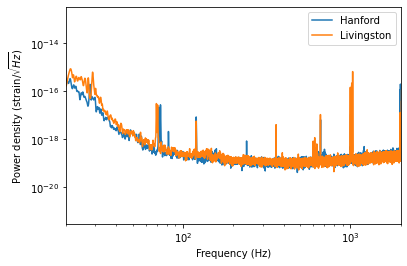

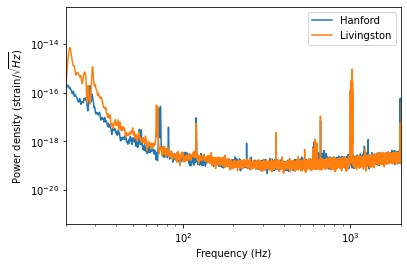

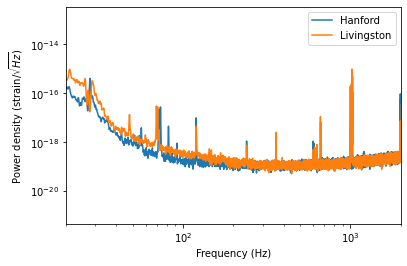

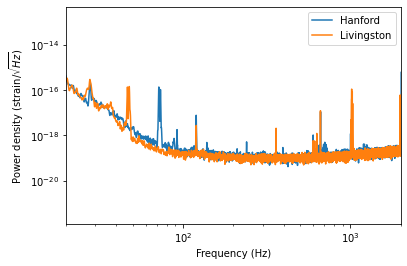

In [17]:
noise_models = get_noise_models(smoothing_std=2, alpha=0.125);

In the above code, I chose to use a Tukey window since it is tapered in the center. I've played with the $\alpha$ parameter to visually fit the power spectrum to the way shown in the slides (and tutorial). Note that we show frequencies up to 2 kHz since, from Nyquist theorem, only frequencies up to 2048 Hz can be correctly represented (because the sampling rate is 4 kHz). Then, the spectrums are smoothed by convoluting them with a Gaussian (with varying width; "optimal" parameter found visually). The final step, as shown in class, is to make sure peaks are kept so we take the maximum at each value.

### b) & c)

#### Grid search for optimal SNR

I've tried for a long time to use to code to find the optimal window and smoothing parameters to increase the SNR, but to no avail. Sometimes I could get insanely high (artificial) SNR and at other times not a significant increase. Hence, I'll leave the code here, but I won't use it. I'll instead just base my parameter selection on the noise plot.

In [18]:
# Compute SNR from matched filter - NOT USED
def compute_SNR(event, plot=False):
    # Hanford
    Aft = np.fft.rfft(event['window'] * event['H_template'])
    sft = np.fft.rfft(event['window'] * event['H_strain'])
    sqrtN = np.sqrt(event['H_noise'])
    mf_ft = np.conj(Aft/sqrtN)*(sft/sqrtN)
    mf = np.fft.irfft(mf_ft)
    
    # Take range around event to estimate noise (without including the event itself)
    max_index = np.argmax(np.abs(mf))
    rolled_mf = np.roll(mf, len(mf)//2 - max_index) # Place event in the middle
    max_index = np.argmax(np.abs(rolled_mf))
    err_range = rolled_mf[max_index - 3500:max_index + 3500] # Range of 7000 points
    #err_range = np.delete(err_range, range(3000, 4001)) # Remove ±500 around event
    
    H_SNR = np.max(np.abs(mf)) / np.std(mf)
    
    if plot:
        plt.figure()
        plt.plot(mf/np.std(mf))
        plt.title("Hanford matched filter")
        plt.show()
        
        print("Hanford SNR ::", H_SNR)
    
    # Livingston
    Aft = np.fft.rfft(event['window'] * event['L_template'])
    sft = np.fft.rfft(event['window'] * event['L_strain'])
    sqrtN = np.sqrt(event['L_noise'])
    mf_ft = np.conj(Aft/sqrtN)*(sft/sqrtN)
    mf = np.fft.irfft(mf_ft)
    
    # Take range around event to estimate noise
    max_index = np.argmax(np.abs(mf))
    rolled_mf = np.roll(mf, len(mf)//2 - max_index) # Place event in the middle
    max_index = np.argmax(np.abs(rolled_mf))
    err_range = rolled_mf[max_index - 3500:max_index + 3500] # Range of 7000 points
    #err_range = np.delete(err_range, range(3000, 4001)) # Remove ±500 around event
    
    L_SNR = np.max(np.abs(mf)) / np.std(mf)
    
    if plot:
        plt.figure()
        plt.plot(mf)
        plt.title("Livingston matched filter")
        plt.show()
        
        print("Livingston SNR ::", L_SNR)
    
    return H_SNR, L_SNR

In [488]:
# Grid search
std_range = np.linspace(0.5, 1000, 51) # Reasonable since length ~ 60k samples
alpha_range = np.linspace(0, 1, 9)

opt_SNR = 0
opt_std = 0
opt_alpha = 0

for std in std_range:
    for alpha in alpha_range:
        # Get noise models
        noise_models = get_noise_models(std, alpha, plot=False)
        
        # Compute average SNR
        SNR = np.average([compute_SNR(event) for event in noise_models])
            
        # Save new parameters if better SNR
        if SNR > opt_SNR:
            opt_SNR = SNR
            opt_std = std
            opt_alpha = alpha
            
            print("New optimal parameters found:")
            print("\tOptimal std ::", opt_std)
            print("\tOptimal alpha ::", opt_alpha)
            print("\tSNR ::", opt_SNR)
            print("")
            
print("Optimal std ::", opt_std)
print("Optimal alpha ::", opt_alpha)
print("SNR ::", opt_SNR)

New optimal parameters found:
	Optimal std :: 0.5
	Optimal alpha :: 0.0
	SNR :: 10.482268805483395

New optimal parameters found:
	Optimal std :: 20.49
	Optimal alpha :: 0.0
	SNR :: 11.324785836880213

New optimal parameters found:
	Optimal std :: 40.48
	Optimal alpha :: 0.0
	SNR :: 11.696898805907178

New optimal parameters found:
	Optimal std :: 60.47
	Optimal alpha :: 0.0
	SNR :: 12.068115163700295

New optimal parameters found:
	Optimal std :: 80.46
	Optimal alpha :: 0.0
	SNR :: 12.532317958600318

New optimal parameters found:
	Optimal std :: 100.44999999999999
	Optimal alpha :: 0.0
	SNR :: 13.04169294961278

New optimal parameters found:
	Optimal std :: 120.44
	Optimal alpha :: 0.0
	SNR :: 13.487044047125623

New optimal parameters found:
	Optimal std :: 140.42999999999998
	Optimal alpha :: 0.0
	SNR :: 13.847373530657805

New optimal parameters found:
	Optimal std :: 160.42
	Optimal alpha :: 0.0
	SNR :: 14.142609024877618

New optimal parameters found:
	Optimal std :: 180.41
	Opt

#### Matched filter


Event :: GW150914


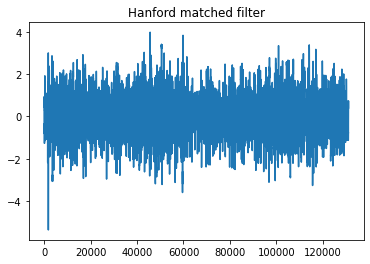

Hanford SNR :: 5.355159506154936


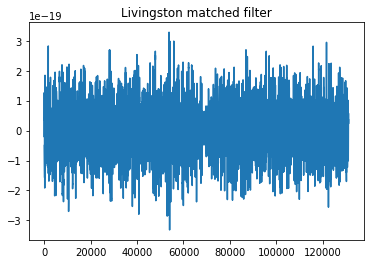

Livingston SNR :: 3.949614469352432

Event :: LVT151012


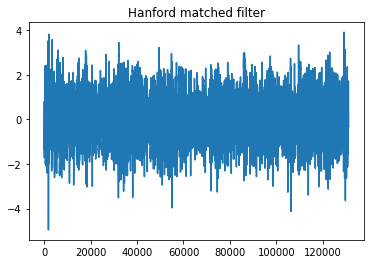

Hanford SNR :: 4.956753927160315


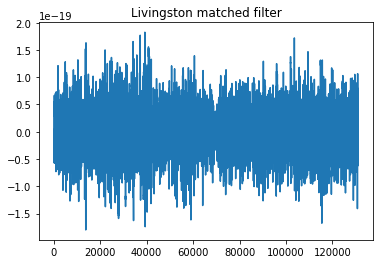

Livingston SNR :: 4.067623059069916

Event :: GW151226


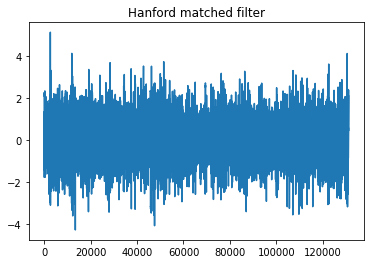

Hanford SNR :: 5.142038406318245


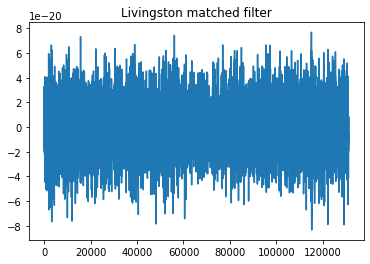

Livingston SNR :: 4.06705755312197

Event :: GW170104


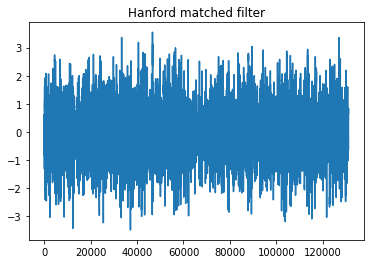

Hanford SNR :: 3.546711484869324


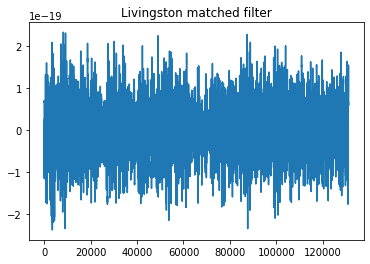

Livingston SNR :: 3.6215165638305087


In [19]:
# Noise models
#noise_models = get_noise_models(opt_std, opt_alpha, plot = False)

# Matched filter
for event in noise_models:
    print("\nEvent ::", event["name"])
    
    compute_SNR(event, plot=True)

#### d)

In [417]:
np.sqrt(np.mean(np.abs(Aft)))

1.978620607612947e-09

In [418]:
A_twiddle = event['L_template']

In [419]:
1/np.sqrt(np.fft.irfft(event['L_noise'])/np.dot(A_twiddle, A_twiddle))

<ipython-input-419-9ec9a7970877>:1: RuntimeWarning: invalid value encountered in sqrt
  1/np.sqrt(np.fft.irfft(event['L_noise'])/np.dot(A_twiddle, A_twiddle))


array([6.35919243e-09, 9.38929629e-09, 6.68367396e-09, ...,
       9.44980213e-09, 6.68367396e-09, 9.38929629e-09])

In [420]:
np.mean(s)

0.00021598389243011093

#### e)

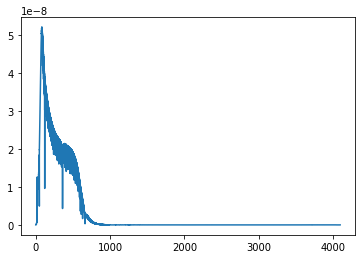

81.62375452034729
249.5586920365595


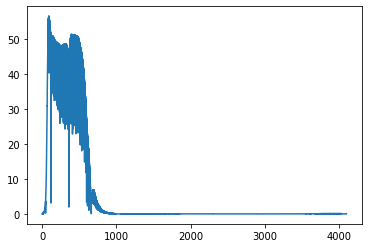

In [421]:
arr = np.abs(Aft/sqrtN)
plt.plot(event['L_freqs'], arr)
plt.show()
print(event['L_freqs'][np.argmax(arr)])

mid = np.sum(np.abs(Aft/sqrtN)/2)
cs = np.cumsum(np.abs(Aft/sqrtN))
print(event['L_freqs'][(cs < mid).sum()])
plt.plot(event['L_freqs'], np.abs(Aft/sqrtN**2))
plt.show()

In [422]:
event

{'name': 'GW170104',
 'H_noise': array([1.62899047e-16, 3.38736915e-16, 4.53011606e-16, ...,
        1.04172562e-16, 1.04208851e-16, 5.68204586e-19]),
 'L_noise': array([1.91318309e-13, 1.87604987e-16, 1.87637182e-16, ...,
        1.87507332e-16, 1.87540039e-16, 5.26906755e-20]),
 'H_freqs': array([0.00000000e+00, 6.24990463e-02, 1.24998093e-01, ...,
        4.09581250e+03, 4.09587500e+03, 4.09593750e+03]),
 'L_freqs': array([0.00000000e+00, 6.24990463e-02, 1.24998093e-01, ...,
        4.09581250e+03, 4.09587500e+03, 4.09593750e+03]),
 'H_strain': array([-3.80273339e-19, -3.85430002e-19, -3.51911262e-19, ...,
         8.25225590e-19,  7.77612450e-19,  7.70090459e-19]),
 'L_strain': array([-1.52957536e-18, -1.56583622e-18, -1.57837349e-18, ...,
        -1.43656549e-18, -1.45874957e-18, -1.43511417e-18]),
 'window': array([1., 1., 1., ..., 1., 1., 1.]),
 'H_template': array([-9.0143326e-20, -9.0041156e-20, -8.9928330e-20, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtyp